In [1]:
import numpy as np
import os
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
from tensorflow.contrib.layers import variance_scaling_initializer
from tensorflow.contrib.layers import fully_connected
from tensorflow.contrib.data import Dataset, Iterator
from sklearn.metrics import f1_score, classification_report
import datetime
import pickle
from nltk.tokenize import TweetTokenizer
import pandas as pd
import re
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
###### Do not modify here ###### 
def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = graph_def
    #strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))
###### Do not modify  here ######

###### Do not modify here ###### 

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)



## Data Preparing

In [2]:
tknzr = TweetTokenizer()

def filter_tweet(tweet, token = tknzr):
    try:
        tweet = re.sub('https?:\/\/\S+','URLTOK',tweet.lower().strip()) # url
        tweet = re.sub('@(?:[a-zA-Z]+|[0-9 \/]+)', '<M>', tweet) # mention
        tweet = re.sub('#(?:[a-zA-Z]+|[0-9 \/]+)', '<H>', tweet) # hashtag
        tweet = re.sub('(\:|\=)(?:\)|\-|\(|D| )+', '', tweet) # emoticon
    except:
        print(tweet)
        return [0]
    return token.tokenize(tweet) # return tokenized



### Load positive data

#### Negative Tweets

In [71]:
with open('data/distance_supervised/sad') as f:
    sad_tweet = [filter_tweet(line) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_2_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]

with open('data/distance_supervised/distance_supervised_tweets_3_corrected') as f:
    sad_tweet += [filter_tweet(line.split('\t')[3]) for line in f.readlines()]
print(len(sad_tweet))


i miss him so much :(
1252941


#### Positive Tweets

In [72]:
with open('data/distance_supervised/smile') as f:
    smile_tweet = [filter_tweet(line) for line in f.readlines()][:len(sad_tweet)]
len(smile_tweet)

1252941

In [80]:
# size filter
max_length = 60

In [81]:


sad_tweet = list(filter(lambda tweet: len(tweet) <= max_length, sad_tweet))
print(len(sad_tweet))
smile_tweet = list(filter(lambda tweet: len(tweet) <= max_length, smile_tweet))
print(len(smile_tweet))

1252345
1252910


### Build Dictionary

In [7]:
from collections import defaultdict
vocabulary_dict = {}
word_index = 0

for tweet in smile_tweet+sad_tweet:
    for word in tweet:
        if word not in vocabulary_dict:
            vocabulary_dict[word] = word_index
            word_index +=1

In [8]:
vocabulary_dict['<m>'] = vocabulary_dict.get('<M>')
vocabulary_dict['<h>'] = vocabulary_dict.get('<h>')
vocabulary_dict['urltok'] = vocabulary_dict.get('URLTOK')

In [9]:
print(vocabulary_dict.get('URLTOK'))
print(vocabulary_dict.get('<M>'))
print(vocabulary_dict.get('<H>'))

349884
349897
170


In [12]:
# transform the tweet sentence to numerical representation
def word_transform(tweet_set, max_length = 60):
    set_array = []
    for tweet in tweet_set:
        tweet_array = [0] * max_length
        for i, word in enumerate(tweet):
            if i == 60: break # remove the words after 60th
            if vocabulary_dict.get(word):
                tweet_array[i] = vocabulary_dict[word]
            else:
                tweet_array[i] = 0
        set_array.append(tweet_array)
    return np.array(set_array)

In [82]:
sad_array = word_transform(sad_tweet, max_length = max_length)
print(sad_array.shape)
smile_array = word_transform(smile_tweet, max_length = max_length)
print(smile_array.shape)

(1252345, 60)
(1252910, 60)


In [83]:
smile_array[0]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 18, 21,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0])

In [84]:
sad_array[0]

array([325, 401,  73, 196,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0])

In [85]:
total_tweets = np.concatenate((smile_array[:sad_array.shape[0]], sad_array), axis=0)
total_labels = np.concatenate((np.zeros(sad_array.shape[0]), np.ones(sad_array.shape[0])), axis=0)

## Prepare Training + Testing Data

In [86]:
# from sklearn.model_selection import ShuffleSplit
# rs = ShuffleSplit(n_splits=1, test_size=.1, random_state=0)

# senti_train = en_train['label'].as_matrix()
# senti_test  = en_test['label'].as_matrix()

# for train_index, test_index in rs.split(senti):
#     X_train = tweets[train_index]
#     y_train = senti[train_index]

#     X_test = tweets[test_index]
#     y_test = senti[test_index]
# X_train.shape

from sklearn.utils import shuffle
X_train, y_train = shuffle(total_tweets, total_labels, random_state=8)

y_train

array([ 0.,  1.,  1., ...,  0.,  1.,  1.])

# Load Pretrain Word2Vec Model (#DIM 200)

In [16]:
# # Load pre train Word2vec
# wb_matrix = np.load("data/embed_tweets_en_200M_200D/embedding_matrix.npy")
# print(wb_matrix.shape)
# vocabulary_dict_ = pickle.load(open("data/embed_tweets_en_200M_200D/vocabulary.pickle", "rb"))
# print(len(vocabulary_dict_))

(1859185, 200)


In [70]:
# Load pre train Word2vec from glove
# wb_matrix = np.zeros((400001,200), np.float32)
# vocabulary_dict_ = {}
# # w2v
# with open('data/embedding/glove.6B.200d.txt') as f:
#     for i, line in enumerate(f.readlines()):
#         line_split = line.split()
#         vocabulary_dict_[line_split[0]] = i+1
#         wb_matrix[i+1] = np.array(line_split[1:])
wb_matrix = np.load("data/embedding/glove6B_200.npy")
print(wb_matrix.shape)
vocabulary_dict_ = pickle.load(open("data/embedding/glove6B_200.pickle", "rb"))
print(len(vocabulary_dict_))

(400001, 200)
400000


In [69]:
print(vocabulary_dict.get('URLTOK'))
print(vocabulary_dict_.get('URLTOK'))

349884
None


In [73]:
 # initial matrix with random uniform
initW = np.random.uniform(-0.25,0.25,(len(vocabulary_dict), wb_matrix.shape[1]))
# load any vectors from the word2vec
for word, index in vocabulary_dict.items():
#     print(word)
#     print(index)
    try:
        idx = vocabulary_dict_.get(word)[0]
    except:
        continue
    
    if idx != 0 and idx is not None:
        initW[index] = wb_matrix[idx]
        
initW.shape

(496893, 200)

# Distance Supervised Learning

In [74]:
n_input = max_length
n_output = 2
learning_rate = 1

embedding_size = initW.shape[1]
filter_sizes = [4,3]
num_filters = 200
pooling_size = 4
pooling_strides = 2
epochs_num = 20
batch_size = 128

In [75]:
def data_iterator():
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X_train), batch_size):
            trains_batch = X_train[batch_idx:batch_idx+batch_size]
            labels_batch = y_train[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator()

In [94]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = initW.shape),
                    trainable=True, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars_expanded, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], initW.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[4, 1], strides=2)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )

pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[27, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu, name = "Fully_connect")
# dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode)

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [87]:
# prepare the training batch
# train_data = tf.contrib.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).repeat()
# train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
# train_next_batch = train_iterator.get_next()

In [95]:
round_of_epochs = int(X_train.shape[0]/batch_size)
print(round_of_epochs)

saver = tf.train.Saver() # to store the model

with tf.Session() as sess:
    # Initialize all variables
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    
    sess.run(word2vec.assign(initW))# Assign the pretrain word2vec
    for _ in range(epochs_num):
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample
            train, label = next(iter_)
            sess.run(train_step, feed_dict={X:train, y:label}) # Feed the features, labe, training_mode  to network to train

        
    distance_supervised_embeddings = sess.run(word2vec)
    

19567


## Distance Supervised Learning Comparsion

In [91]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


In [92]:
def draw_plot(words, matrix, v_dic, nbest=15):
    word_vectors = []
    for word in words:
        index = v_dic[word]
        word_vectors.append(matrix[index])  
    pca = PCA(n_components=2)  
    pca.fit(word_vectors)
    X = pca.transform(word_vectors)
    
    xs = X[:, 0]
    ys = X[:, 1]

    # draw
    plt.figure(figsize=(12,8))
    plt.scatter(xs, ys, marker = 'o')
    for i, w in enumerate(words):
        plt.annotate(w, (xs[i], ys[i]))

    plt.show()

Word2vec with distance supervised learning

Before


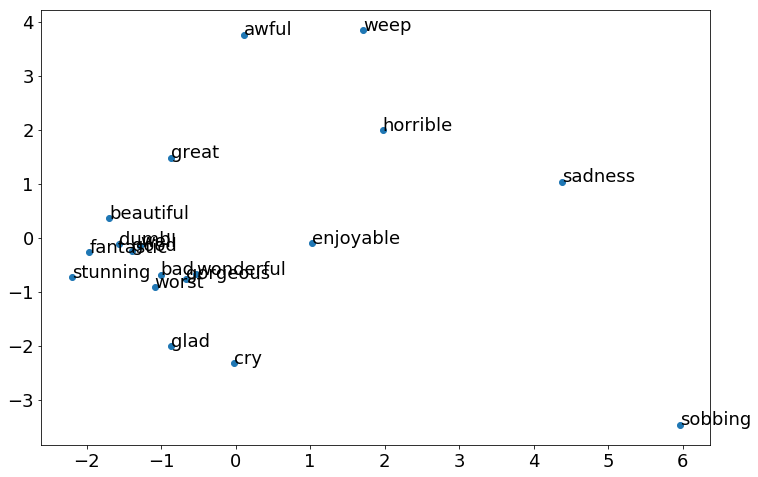

After


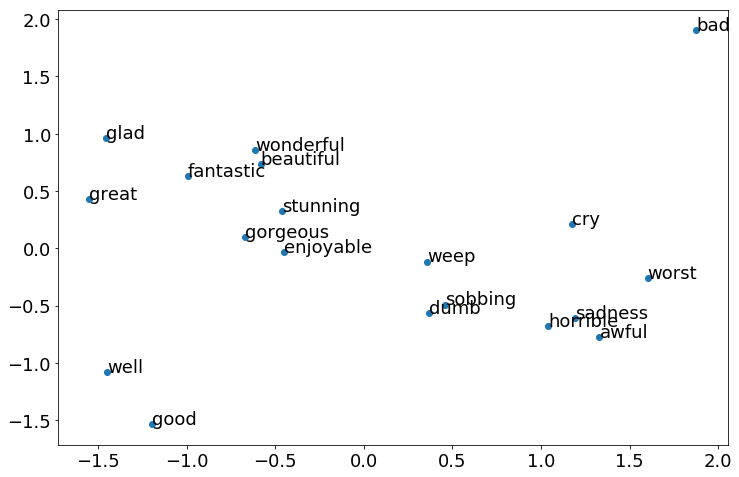

In [96]:
words = ['sadness', 'sobbing', 'cry', 'weep', 'horrible', 'worst', 'awful', 'enjoyable', 'wonderful',
         'bad', 'fantastic', 'great', 'good', 'beautiful', 'stunning','gorgeous','glad','well','dumb']

plt.rcParams['font.size'] = 18

print("Word2vec with distance supervised learning\n")
print("Before")
draw_plot(words, wb_matrix, vocabulary_dict)
print("After")
draw_plot(words, distance_supervised_embeddings, vocabulary_dict)

In [99]:
del wb_matrix, vocabulary_dict_, X_train, y_train, smile_array, smile_tweet, sad_array, sad_tweet

### Dump model

In [100]:
# np.save('data/embedding/distance_supervised_2M_200', distance_supervised_embeddings)
# with open('data/embedding/distance_supervised_2M_200.pickle', 'wb') as f:
#     pickle.dump(vocabulary_dict,f)

np.save('data/embedding/distance_supervised_Glove_200', distance_supervised_embeddings)
with open('data/embedding/distance_supervised_Glove_200.pickle', 'wb') as f:
    pickle.dump(vocabulary_dict,f)

### Load model

In [3]:
# Load pre train Word2vec
distance_supervised_embeddings = np.load("data/embedding/distance_supervised_2M_200.npy")
print(distance_supervised_embeddings.shape)
# distance_supervised_embeddings_glove = np.load("data/embedding/distance_supervised_Glove_200.npy")
# print(distance_supervised_embeddings_glove.shape)

vocabulary_dict = pickle.load(open("data/embedding/distance_supervised_2M_200.pickle", "rb"))
print(len(vocabulary_dict))



(496894, 200)
496893


In [4]:
words_num, dims_num = distance_supervised_embeddings.shape
multi_embeddings = np.concatenate((distance_supervised_embeddings.reshape((words_num, dims_num, 1)), distance_supervised_embeddings_glove.reshape((words_num, dims_num, 1))), axis=2)
multi_embeddings.shape

(496894, 200, 2)

# Supervised Learning

In [4]:
def emotion2label(emo):
    if emo =='joy':            return 0
    elif emo =='anticipation': return 1
    elif emo =='trust':        return 2
    elif emo =='surprise':     return 3
    elif emo =='sadness':      return 4
    elif emo =='fear':         return 5
    elif emo =='anger':        return 6
    elif emo =='disgust':      return 7

In [5]:
# Load Training data
en_train = pd.read_csv('data/emo/Train/train.tsv', delimiter='\t', names=["emotion", "tweet"])
en_train.head()



,emotion,tweet
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...
1,anger,stop posting every damn thing you do on instag...
2,trust,<H> youll never meet justin bieber. hell never...
3,anticipation,<H> &amp; count down the days until May! <H> <...
4,surprise,<M> Holme upon Spalding moor won rock challeng...


In [6]:
en_train.groupby('emotion').count()

,tweet
emotion,
anger,332416
anticipation,86100
disgust,17966
fear,352271
joy,351119
sadness,439736
surprise,165751
trust,220511


In [7]:

# Load Testing data
en_test = pd.read_csv('data/emo/Test/test.tsv', delimiter='\t',names=["tweet","emotion", "emotion2", "emotion3"])
en_test.head()

,tweet,emotion,emotion2,emotion3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN
2,#sterlings getting some great experience here....,joy,trust,anticipation
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust
4,1 week from today! the @championsleague return...,anticipation,joy,trust


In [8]:
en_train['label'] = en_train['emotion'].map(emotion2label)
en_train.head()


,emotion,tweet,label
0,anticipation,<M>: <H> <H> <H> <H> <H> <H> <M> ... You DTM. ...,1
1,anger,stop posting every damn thing you do on instag...,6
2,trust,<H> youll never meet justin bieber. hell never...,2
3,anticipation,<H> &amp; count down the days until May! <H> <...,1
4,surprise,<M> Holme upon Spalding moor won rock challeng...,3


In [9]:

en_test['label'] = en_test['emotion'].map(emotion2label).fillna(-1).astype('int')
en_test['label2'] = en_test['emotion2'].map(emotion2label).fillna(-1).astype('int')
en_test['label3'] = en_test['emotion3'].map(emotion2label).fillna(-1).astype('int')
en_test.head()

,tweet,emotion,emotion2,emotion3,label,label2,label3
0,#championsleague i am cmng to watch you...all ...,joy,anticipation,trust,0,1,2
1,#mufc wages up19% in13/14 season with #dimaria...,anticipation,fear,NaN,1,5,-1
2,#sterlings getting some great experience here....,joy,trust,anticipation,0,2,1
3,1 more week then it's block 208 kop grandstand...,anticipation,joy,trust,1,0,2
4,1 week from today! the @championsleague return...,anticipation,joy,trust,1,0,2


In [10]:
en_test.groupby('emotion').count()

,tweet,emotion2,emotion3,label,label2,label3
emotion,,,,,,
anger,223,194,57,223,223,223
anticipation,272,146,61,272,272,272
disgust,183,118,91,183,183,183
fear,119,99,43,119,119,119
joy,591,356,93,591,591,591
sadness,218,176,64,218,218,218
surprise,246,187,49,246,246,246
trust,102,94,59,102,102,102


In [11]:
%%time
train_tweet = [filter_tweet(tweet) for tweet in en_train['tweet']]
test_tweet = [filter_tweet(tweet) for tweet in en_test['tweet']]


print(len(train_tweet))
print(len(test_tweet))

1965870
1954
CPU times: user 1min 6s, sys: 336 ms, total: 1min 6s
Wall time: 1min 6s


In [13]:
%%time
max_length = 60
tweets_train_all = word_transform(train_tweet, max_length = max_length)
print(tweets_train_all.shape)
tweets_test = word_transform(test_tweet, max_length = max_length)
print(tweets_test.shape)

senti_train_all = en_train['label'].as_matrix()
senti_test  = en_test['label'].as_matrix()
senti_test2  = en_test['label2'].as_matrix()
senti_test3  = en_test['label3'].as_matrix()

(1965870, 60)
(1954, 60)
CPU times: user 17.7 s, sys: 212 ms, total: 17.9 s
Wall time: 17.9 s


## Word Energy Vector

In [63]:
import sys
sys.path.append('./library/English_to_IPA/src/')
import conversion as cv
from joblib import Parallel, delayed
from scipy.sparse import vstack

In [24]:
print(cv.convert('some'))

('s ah1 m', 'sʌ m')


In [26]:
eSPEDictV2 = dict()
with open('./library/eSPEPhonologicalTableV2.txt') as openFile:
    for line in openFile.readlines():
        line = line.strip().split('\t')
        eSPEDictV2[line[0]] = np.array([eval(x) for x in line[1:]])

In [112]:
### (8 classes + 1 class:#(words))
def getWordScore(word):
    score = np.zeros((8,))
    # 字典裡找不到這個字
    if word == "<m>" or word =="<h>" or word == "urltok": return 0
    try:
        cmu, ipa = cv.convert(word)
    except:
        return 0
    ipa = re.sub('[ˌ\ˈ ]' ,'' ,ipa)
    if '*' in ipa:
        return 0
    i = 0
    while i < len(ipa):
        # 最後一個音標
        if i == len(ipa)-1:
            sym = ipa[i]
            if sym in eSPEDictV2:
                score += eSPEDictV2[sym]
            i += 1
        # 非最後一個音標
        else:
            try:
                sym = ipa[i] + ipa[i+1]
                score += eSPEDictV2[sym]
                i += 2
            except KeyError:
                sym = ipa[i]
                if sym in eSPEDictV2:
                    score += eSPEDictV2.get(sym)
                i += 1
    return score

def getTweetScoreV2(words):
    wordCount = 0.0
    score = np.zeros((8,))
    for word in words:
        # 字典裡找不到這個字
        if word == "<m>" or word =="<h>" or word == "urltok": continue
        try:
#             print(word)
            cmu, ipa = cv.convert(word)
        except:
            continue
        ipa = re.sub('[ˌ\ˈ ]' ,'' ,ipa)
        if '*' in ipa:
            continue
        wordCount += 1
        i = 0
        while i < len(ipa):
            # 最後一個音標
            if i == len(ipa)-1:
                sym = ipa[i]
                if sym in eSPEDictV2:
                    score += eSPEDictV2[sym]
                i += 1
            # 非最後一個音標
            else:
                try:
                    sym = ipa[i] + ipa[i+1]
                    score += eSPEDictV2[sym]
                    i += 2
                except KeyError:
                    sym = ipa[i]
                    if sym in eSPEDictV2:
                        score += eSPEDictV2.get(sym)
                    i += 1
    if wordCount != 0:
        return score/wordCount
    else:
        return 0
    
def getPhonScoreV2(tweets_list):
    phon_feature = np.zeros((len(tweets_list),8), np.float32)
#     phon_feature = getTweetScoreV2(tweets_list[0])
    for i, tweets in enumerate(tweets_list):
        phon_feature[i] = getTweetScoreV2(tweets)
    return phon_feature
    
def transform_parrallel(documents, n_jobs=1, n_chunk=500):
    chunks = [documents[i:i + n_chunk] for i in range(0, len(documents), n_chunk)]
    res = Parallel(n_jobs=n_jobs, verbose=0)(delayed(getPhonScoreV2)(chunk) for chunk in chunks)
    return np.vstack(res)


In [113]:
getWordScore('No')

array([ 3.,  3.,  1.,  1.,  1.,  1.,  1.,  1.])

In [106]:
getTweetScoreV2([0])

array([ 6.        ,  2.        ,  3.66666667,  1.        ,  1.33333333,
        1.        ,  1.        ,  1.33333333])

In [114]:
%%time

tweets_train_phon = transform_parrallel(train_tweet, n_jobs=8)
print(tweets_train_phon.shape)
tweets_test_phon = transform_parrallel(test_tweet, n_jobs=8)
print(tweets_test_phon.shape)

(1965870, 8)
(1954, 8)


## Pattern Vector

### Train Validation Split 

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
tweets_train, tweets_valid, senti_train, senti_valid = train_test_split(tweets_train_all, senti_train_all, test_size=0.1, random_state=42)
print(tweets_train.shape)
print(tweets_valid.shape)

(1769283, 60)
(196587, 60)


### Build Model

In [18]:
import os
# os.makedirs("./model")

In [19]:
n_input = max_length
n_output = 8
learning_rate = 1

embedding_size = distance_supervised_embeddings.shape[1]
filter_sizes = [2,3]
num_filters = 400
pooling_size = 3
pooling_strides = 2
epochs_num = 5
batch_size = 256

### Multi channel word embedding

In [21]:
reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = multi_embeddings.shape),
                           trainable=False, name="word2vec_twitter") # trainable=False, means not update these embeddings
    
embedded_chars = tf.nn.embedding_lookup(word2vec, X)
# embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

print(embedded_chars.shape)

# 1st convolution layer
conv1 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
#                          padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv2 = tf.layers.conv2d(pool1, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )
print(conv2.shape)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[29, 1], strides=1)

# Dense Layer, Combine all the pooled features
pool2_flat = tf.reshape(pool2, [-1, num_filters])

dense = tf.layers.dropout(inputs = pool2_flat, rate = 0.3, training = mode, name="Dropout")

dense = tf.layers.dense(inputs=dense, units=1024, activation=tf.nn.relu, name = "Fully_connect")

dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode, name="Dropout_2")

dense = tf.layers.dense(inputs=dense, units=512, activation=tf.nn.relu, name = "Fully_connect_2")

dense = tf.layers.dropout(inputs = dense, rate = 0.3, training = mode, name="Dropout_3")

# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


(?, 60, 200, 2)
(?, 29, 1, 400)


In [139]:
# reset_graph()

# X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
# y = tf.placeholder(tf.int32, shape = (None), name = "Y")
# mode = tf.placeholder(tf.bool, name = "Mode")

# # Load Embedding Model
# with tf.device('/cpu:0'), tf.name_scope("embedding"):
#     word2vec = tf.Variable(tf.constant(0.0, shape = distance_supervised_embeddings.shape),
#                     trainable=False, name="word2vec") # trainable=False, means not update these embeddings

# embedded_chars = tf.nn.embedding_lookup(word2vec, X)
# embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# # 1st convolution layer
# conv1 = tf.layers.conv2d(embedded_chars_expanded, 
#                          filters = num_filters, 
#                          kernel_size = (filter_sizes[0], distance_supervised_embeddings.shape[1]),
#                          strides = (1,1), 
# #                          padding="same",
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         
#                          activation = tf.nn.relu,
#                          name="Convolution_1st"
#                         )

# pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[pooling_size, 1], strides=pooling_strides)

# # 2nd convolution layer
# conv2 = tf.layers.conv2d(pool1, 
#                          filters = num_filters, 
#                          kernel_size = (filter_sizes[1], 1),
#                          strides = (1,1), 
#                          padding="same",
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
#                          activation = tf.nn.relu,
#                          name="Convolution_2nd"
#                         )
# print(conv2.shape)
# pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[29, 1], strides=1)

# # Dense Layer, Combine all the pooled features
# pool2_flat = tf.reshape(pool2, [-1, num_filters])

# dense = tf.layers.dropout(inputs = pool2_flat, rate = 0.3, training = mode, name="Dropout")

# dense = tf.layers.dense(inputs=dense, units=1024, activation=tf.nn.relu, name = "Fully_connect")


# # Logits Layer
# logits = tf.layers.dense(inputs=dense, 
#                          units=n_output, 
#                          activation=tf.nn.softmax, 
# #                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
#                          name = "Softmax")

# # Define Loss Function
# cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# # Define Training Process
# train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# # Define Accuracy
# predicted_class = tf.argmax(logits,1, output_type=tf.int32)
# correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
# accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


In [140]:
# # prepare the training batch in tensorflow
# train_data = tf.contrib.data.Dataset.from_tensor_slices((tweets_train, senti_train)).batch(batch_size).repeat()
# train_iterator = train_data.make_one_shot_iterator() # Create an iterator to go through the training data
# train_next_batch = train_iterator.get_next()

In [22]:
# prepare the training batch in python

def data_iterator(X, y):
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            labels_batch = y[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator(tweets_train, senti_train)

valid_iter_ = data_iterator(tweets_valid, senti_valid)

/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-12-19 14:50:42 -   1 epoch, loss:1.646, accuracy:0.637/0.534, f1-score:0.589/0.496, test acc:0.297
2017-12-19 14:53:22 -   2 epoch, loss:1.642, accuracy:0.629/0.550, f1-score:0.583/0.510, test acc:0.302
2017-12-19 14:56:01 -   3 epoch, loss:1.682, accuracy:0.594/0.555, f1-score:0.551/0.514, test acc:0.329
2017-12-19 14:58:54 -   4 epoch, loss:1.653, accuracy:0.621/0.561, f1-score:0.570/0.521, test acc:0.291
2017-12-19 15:01:48 -   5 epoch, loss:1.674, accuracy:0.602/0.566, f1-score:0.552/0.524, test acc:0.307


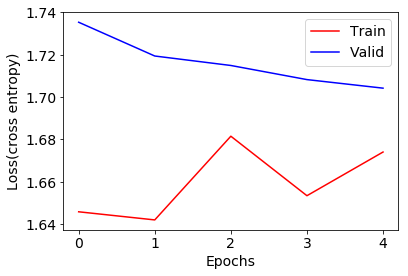

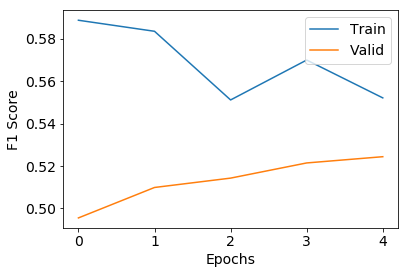

In [23]:
round_of_epochs = int(tweets_train.shape[0]/batch_size)
valid_rounds_of_epochs = int(tweets_valid.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []
x_axis = np.arange(0., epochs_num, 1)
saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []
with tf.Session() as sess:
    # Initialize all variables
#     if os.path.exists('./model/emo_504.ckpt.meta'):
#         print ("Model Restore")
#         saver.restore(sess, './model/emo_504.ckpt')
#     else:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(word2vec.assign(multi_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for _ in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
            train, label = next(iter_) # Get the mini-batch data sample from tensorflow

            sess.run(train_step, feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train

        # An epoch finish
        
        loss, pred, acc = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:train, y:label, mode:False})
        
        # Validation
        valid_loss_list = []
        predict_res = np.zeros(batch_size)
        t_label = np.zeros(batch_size)
        valid_acc_list = []
        for _ in range(valid_rounds_of_epochs):
            x_valid, y_valid = next(valid_iter_) # Get the mini-batch data sample from tensorflow
            t_loss, t_pred, t_accuracy = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:x_valid, y:y_valid, mode:False})
            valid_loss_list.append(t_loss)
            predict_res = np.concatenate((predict_res, t_pred))
            t_label = np.concatenate((t_label, y_valid))
            valid_acc_list.append(t_accuracy)
        # An epoch finish
#         t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_valid, y:senti_valid})
        train_loss.append(loss)
        test_loss.append(sum(valid_loss_list)/len(valid_loss_list))
        train_f1.append(f1_score(label, pred, average='weighted'))
        test_f1.append(f1_score(t_label[1:], predict_res[1:], average='weighted'))
        
        t_acc = sum(valid_acc_list)/len(valid_acc_list)
        
        test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
        print("{} - {:3d} epoch, loss:{:.3f}, accuracy:{:.3f}/{:.3f}, f1-score:{:.3f}/{:.3f}, test acc:{:.3f}".format(
            datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            epochs+1,
            loss, 
            acc,
            t_acc,
            f1_score(label, pred, average='weighted'),
            f1_score(t_label[1:], predict_res[1:], average='weighted'),
            test_acc
            )
        )
        
        testing_res.append(test_pred)
        if best_valid_acc < t_acc:
            best_valid_acc = t_acc
            save_path = saver.save(sess, "./model/emo_"+str(t_acc)[2:5]+".ckpt")
        
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    

In [235]:
# # restore graph
# with tf.Session() as sess:
#     saver = tf.train.import_meta_graph('./model/emo_504.ckpt.meta')
#     saver.restore(sess, tf.train.latest_checkpoint('./model/'))
# #     saver.restore(sess, './model/emo_504.ckpt.meta')
#     sess.run(tf.global_variables_initializer())
# #     sess.run(word2vec.assign(distance_supervised_embeddings))# Assign the pretrain word2vec
#     # input the testing tweets
    

# Testing Evalution

In [24]:
from sklearn.metrics import confusion_matrix
import itertools

In [25]:
def label2emotion(label):
    if label == 0:            return 'joy'
    elif label == 1: return 'anticipation'
    elif label == 2:        return 'trust'
    elif label == 3:     return 'surprise'
    elif label == 4:      return 'sadness'
    elif label == 5:         return 'fear'
    elif label == 6:        return 'anger'
    elif label == 7:      return 'disgust'

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
eva_res = pd.DataFrame({'pred':testing_res[2]})

In [27]:
eva_res['emotion'] = eva_res['pred'].map(label2emotion)

In [28]:
class_names = ['joy','anticipation','trust','surprise','sadness','fear','anger','disgust']
cfm = confusion_matrix(en_test.emotion, eva_res.emotion, labels=class_names)

In [29]:
print(classification_report(en_test.emotion, eva_res.emotion, target_names=class_names))

              precision    recall  f1-score   support

         joy       0.36      0.37      0.37       223
anticipation       0.00      0.00      0.00       272
       trust       0.00      0.00      0.00       183
    surprise       0.12      0.36      0.18       119
     sadness       0.61      0.55      0.58       591
        fear       0.21      0.68      0.33       218
       anger       0.00      0.00      0.00       246
     disgust       0.30      0.40      0.34       102

 avg / total       0.27      0.33      0.28      1954



/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Normalized confusion matrix


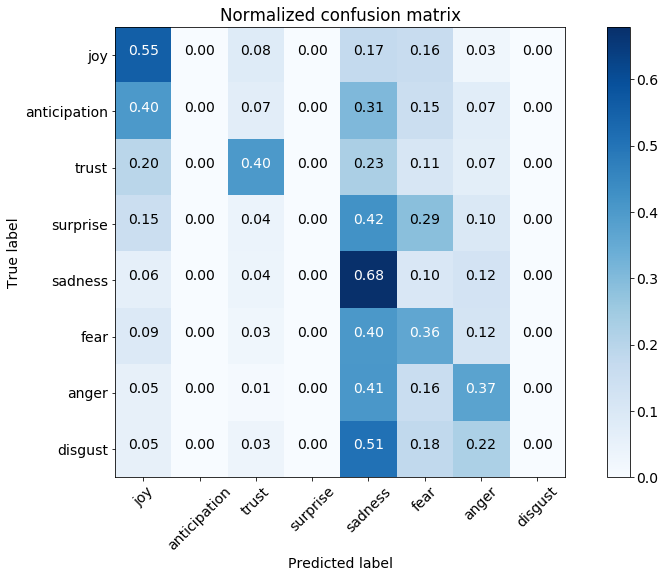

In [30]:

# Plot non-normalized confusion matrix
# plt.figure(figsize=(12,8))
# plot_confusion_matrix(cfm, classes=class_names,
#                       title='Confusion matrix, without normalization')
# plt.show()
# Plot normalized confusion matrix
plt.figure(figsize=(12,8))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
emo_eval_dict = {'joy':         0,
                 'surprise':    0,
                 'trust':       0,
                 'anticipation':0,
                 'fear':        0,
                 'sadness':     0,
                 'disgust':     0,
                 'anger':       0
                 }

emo_total_dict = {'joy':         0,
                  'surprise':    0,
                  'trust':       0,
                  'anticipation':0,
                  'fear':        0,
                  'sadness':     0,
                  'disgust':     0,
                  'anger':       0
                  }

In [32]:
correct = 0
first_correct = 0
emo_first_correct_dict = dict(emo_eval_dict)
emo_correct_dict = dict(emo_eval_dict)
for i, emo in enumerate(eva_res['emotion']):
    emo_total_dict[emo] += 1
    if emo == en_test.emotion[i]:
        first_correct += 1
        emo_first_correct_dict[emo] += 1
        correct += 1
        emo_correct_dict[emo] +=1
    elif emo == en_test.emotion2[i]:
        correct += 1
        emo_correct_dict[emo] +=1

In [33]:
correct/eva_res.shape[0]

0.43654042988741043

## Parallen N-gram CNN

In [35]:
num_filters = 300
pooling_strides = 1

reset_graph()

X = tf.placeholder(tf.int32, shape = (None, n_input), name = "Input_X")
y = tf.placeholder(tf.int32, shape = (None), name = "Y")
mode = tf.placeholder(tf.bool, name = "Mode")

# Load Embedding Model
with tf.device('/cpu:0'), tf.name_scope("embedding"):
    word2vec = tf.Variable(tf.constant(0.0, shape = multi_embeddings.shape),
                    trainable=False, name="word2vec") # trainable=False, means not update these embeddings

embedded_chars = tf.nn.embedding_lookup(word2vec, X)
# embedded_chars_expanded = tf.expand_dims(embedded_chars, -1) # ex: convert [[1,2]] to [[1],[2]], that is shape (2,) to (2,1)

# 1st convolution layer
conv11 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (3, distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st"
                        )

pool11 = tf.layers.max_pooling2d(inputs=conv11, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv21 = tf.layers.conv2d(pool11, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1), 
                         padding="same",
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd"
                        )
print(conv21.shape)
pool21 = tf.layers.max_pooling2d(inputs=conv21, pool_size=[56, 1], strides=1)

# Dense Layer, Combine all the pooled features
# pool21_flat = tf.reshape(pool21, [-1, num_filters])

# 1st convolution layer
conv12 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (4, distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st_2"
                        )

pool12 = tf.layers.max_pooling2d(inputs=conv12, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv22 = tf.layers.conv2d(pool12, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1),
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd_2"
                        )
print(conv22.shape)
pool22 = tf.layers.max_pooling2d(inputs=conv22, pool_size=[53, 1], strides=1)

# Dense Layer, Combine all the pooled features
# pool22_flat = tf.reshape(pool22, [-1, num_filters])

# 1st convolution layer
conv13 = tf.layers.conv2d(embedded_chars, 
                         filters = num_filters, 
                         kernel_size = (5, distance_supervised_embeddings.shape[1]),
                         strides = (1,1), 
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_1st_3"
                        )

pool13 = tf.layers.max_pooling2d(inputs=conv13, pool_size=[pooling_size, 1], strides=pooling_strides)

# 2nd convolution layer
conv23 = tf.layers.conv2d(pool13, 
                         filters = num_filters, 
                         kernel_size = (filter_sizes[1], 1),
                         strides = (1,1),
                         kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         activation = tf.nn.relu,
                         name="Convolution_2nd_3"
                        )
print(conv23.shape)
pool23 = tf.layers.max_pooling2d(inputs=conv23, pool_size=[50, 1], strides=1)

print(pool23.shape)

# Dense Layer, Combine all the pooled features
# pool23_flat = tf.reshape(pool23, [-1, num_filters])

# print(pool21_flat.shape)
# print(pool22_flat.shape)
# print(pool23_flat.shape)

# conv_concat = tf.concat([pool21_flat, pool22_flat, pool23_flat], 1)

conv_concat = tf.concat([pool21, pool22, pool23], 1)

print(conv_concat.shape)

conv_concat = tf.reshape(conv_concat, [-1, 5*num_filters])

print(conv_concat.shape)

dense = tf.layers.dropout(inputs = conv_concat, rate = 0.3, training = mode)

dense = tf.layers.dense(inputs=dense, units=1024, activation=tf.nn.relu, name = "Fully_connect")


# Logits Layer
logits = tf.layers.dense(inputs=dense, 
                         units=n_output, 
                         activation=tf.nn.softmax, 
#                          kernel_initializer=tf.contrib.layers.variance_scaling_initializer(),
                         name = "Softmax")

# Define Loss Function
cross_entropy = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits, name="Cross_Entropy"))

# Define Training Process
train_step = tf.train.AdadeltaOptimizer(learning_rate, epsilon=1e-6).minimize(cross_entropy)

# Define Accuracy
predicted_class = tf.argmax(logits,1, output_type=tf.int32)
correct_predict = tf.equal(y, predicted_class) # [True, False ..., True]
accuracy = tf.reduce_mean(tf.cast(correct_predict, tf.float32)) # [True, False ..., True] --> [1,0,...,1]


(?, 56, 1, 300)
(?, 53, 1, 300)
(?, 52, 1, 300)
(?, 3, 1, 300)
(?, 5, 1, 300)
(?, 1500)


In [36]:
with tf.Session() as sess:
    show_graph(tf.get_default_graph().as_graph_def())
    # Initialize all variables
#     sess.run(tf.local_variables_initializer())
#     sess.run(tf.global_variables_initializer())
    
#     sess.run(word2vec.assign(initW))# Assign the pretrain word2vec


/home/yenhao/Documents/chatbot/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


2017-12-19 15:22:55 -   1 epoch,     1 round, loss:2.096, acc:0.059/0.082, f1:0.044/0.065, test acc:0.157
2017-12-19 15:23:43 -   1 epoch,   501 round, loss:1.842, acc:0.422/0.425, f1:0.350/0.366, test acc:0.242
2017-12-19 15:24:30 -   1 epoch,  1001 round, loss:1.812, acc:0.449/0.457, f1:0.389/0.392, test acc:0.304
2017-12-19 15:25:18 -   1 epoch,  1501 round, loss:1.833, acc:0.438/0.463, f1:0.365/0.397, test acc:0.296
2017-12-19 15:26:06 -   1 epoch,  2001 round, loss:1.853, acc:0.418/0.460, f1:0.348/0.394, test acc:0.327
2017-12-19 15:26:53 -   1 epoch,  2501 round, loss:1.750, acc:0.516/0.501, f1:0.482/0.463, test acc:0.278
2017-12-19 15:27:41 -   1 epoch,  3001 round, loss:1.760, acc:0.500/0.510, f1:0.462/0.469, test acc:0.347
2017-12-19 15:28:29 -   1 epoch,  3501 round, loss:1.773, acc:0.496/0.518, f1:0.455/0.477, test acc:0.307
2017-12-19 15:29:16 -   1 epoch,  4001 round, loss:1.821, acc:0.449/0.521, f1:0.404/0.483, test acc:0.267
2017-12-19 15:30:04 -   1 epoch,  4501 round, 

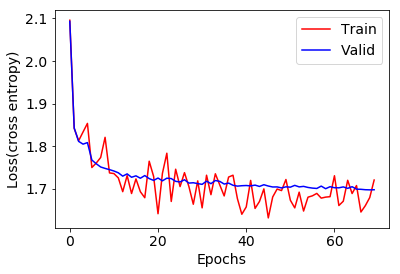

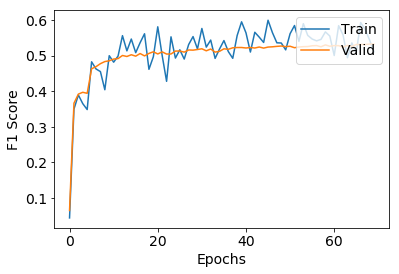

In [37]:
# prepare the training batch in python

def data_iterator(X, y):
    """ A simple data iterator """
    batch_idx = 0
    while True:
        for batch_idx in range(0, len(X), batch_size):
            trains_batch = X[batch_idx:batch_idx+batch_size]
            labels_batch = y[batch_idx:batch_idx+batch_size]
            yield trains_batch, labels_batch


iter_ = data_iterator(tweets_train, senti_train)

valid_iter_ = data_iterator(tweets_valid, senti_valid)
round_of_epochs = int(tweets_train.shape[0]/batch_size)
valid_rounds_of_epochs = int(tweets_valid.shape[0]/batch_size)

train_loss = []
test_loss  = []

train_f1 = []
test_f1 = []

saver = tf.train.Saver() # to store the model

best_valid_acc = 0

testing_res = []

validation_rounds = 0
epochs_num = 5
with tf.Session() as sess:
    # Initialize all variables
#     if os.path.exists('./model/emo_504.ckpt.meta'):
#         print ("Model Restore")
#         saver.restore(sess, './model/emo_504.ckpt')
#     else:
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(word2vec.assign(multi_embeddings))# Assign the pretrain word2vec
    
    for epochs in range(epochs_num): # starting the training process and set the epochs_num
        for roun in range(round_of_epochs):
#             train, label = sess.run(train_next_batch) # Get the mini-batch data sample from tensorflow
            train, label = next(iter_) # Get the mini-batch data sample from tensorflow

            if roun % 500 == 0: # go to validation
                validation_rounds +=1
                
                # Round finish
                loss, pred, acc = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:train, y:label, mode:False})

                # Validation
                valid_loss_list = []
                predict_res = np.zeros(batch_size)
                t_label = np.zeros(batch_size)
                valid_acc_list = []
                for _ in range(valid_rounds_of_epochs):
                    x_valid, y_valid = next(valid_iter_) # Get the mini-batch data sample from tensorflow
                    t_loss, t_pred, t_accuracy = sess.run([cross_entropy, predicted_class, accuracy], feed_dict={X:x_valid, y:y_valid, mode:False})
                    valid_loss_list.append(t_loss)
                    predict_res = np.concatenate((predict_res, t_pred))
                    t_label = np.concatenate((t_label, y_valid))
                    valid_acc_list.append(t_accuracy)
                # An epoch finish
        #         t_loss, t_pred = sess.run([cross_entropy,predicted_class], feed_dict={X:tweets_valid, y:senti_valid})
                train_loss.append(loss)
                test_loss.append(sum(valid_loss_list)/len(valid_loss_list))
                train_f1.append(f1_score(label, pred, average='weighted'))
                test_f1.append(f1_score(t_label[1:], predict_res[1:], average='weighted'))

                t_acc = sum(valid_acc_list)/len(valid_acc_list)

                test_pred, test_acc = sess.run([predicted_class, accuracy], feed_dict={X:tweets_test, y:senti_test, mode:False})
                print("{} - {:3d} epoch, {:5d} round, loss:{:.3f}, acc:{:.3f}/{:.3f}, f1:{:.3f}/{:.3f}, test acc:{:.3f}".format(
                    datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                    epochs+1,
                    roun+1,
                    loss, 
                    acc,
                    t_acc,
                    f1_score(label, pred, average='weighted'),
                    f1_score(t_label[1:], predict_res[1:], average='weighted'),
                    test_acc
                    )
                )
                testing_res.append(test_pred)
            # Train
            sess.run(train_step, feed_dict={X:train, y:label, mode:True}) # Feed the features, labe, training_mode  to network to train  
        
#         if best_valid_acc < t_acc:
#             best_valid_acc = t_acc
#             save_path = saver.save(sess, "./model/emo_"+str(t_acc)[2:5]+".ckpt")
    
    x_axis = np.arange(0., validation_rounds, 1)
    plt.rcParams['font.size'] = 14
    plt.plot(x_axis, train_loss, 'r', x_axis, test_loss, 'b')
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss(cross entropy)')
    plt.show()
    plt.clf()
    plt.plot(x_axis, train_f1, x_axis, test_f1)
    plt.legend(['Train', 'Valid'], loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.show()

    

Normalized confusion matrix


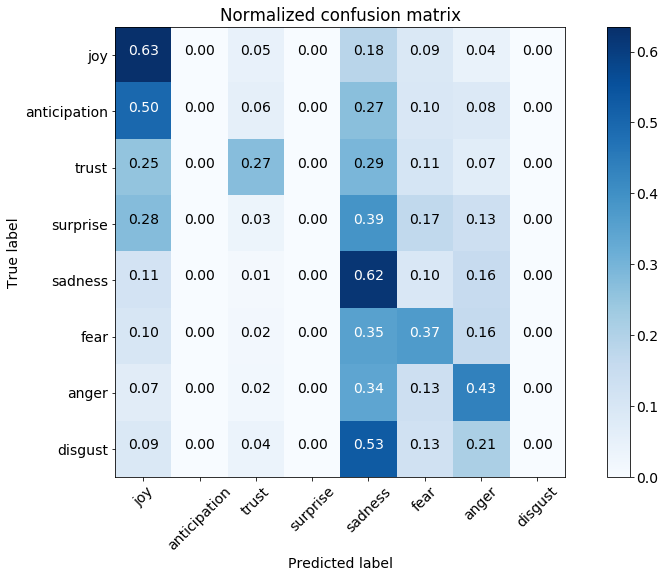

In [38]:
eva_res = pd.DataFrame({'pred':testing_res[6]})
eva_res['emotion'] = eva_res['pred'].map(label2emotion)
cfm = confusion_matrix(en_test.emotion, eva_res.emotion, labels=class_names)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Normalized confusion matrix


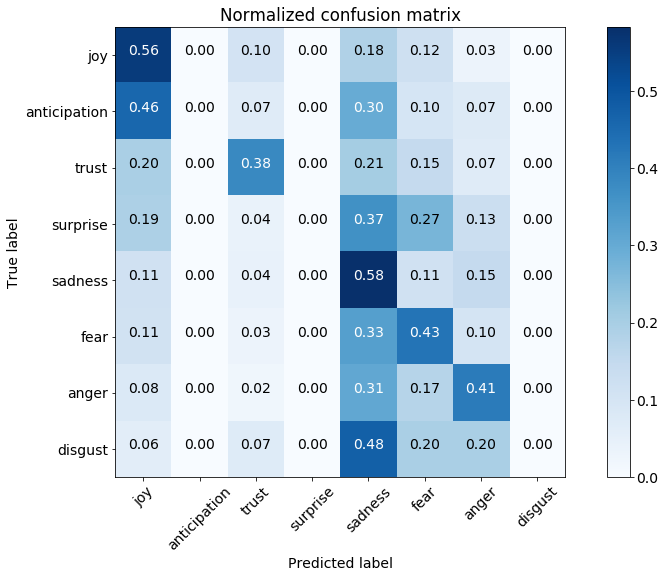

In [39]:
eva_res = pd.DataFrame({'pred':testing_res[52]})
eva_res['emotion'] = eva_res['pred'].map(label2emotion)
cfm = confusion_matrix(en_test.emotion, eva_res.emotion, labels=class_names)
plt.figure(figsize=(12,8))
plot_confusion_matrix(cfm, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()